# Loading the Kaggle API

In [12]:
! pip install kaggle

In [13]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [14]:
! cp kaggle.json ~/.kaggle/

In [15]:
! chmod 600 ~/.kaggle/kaggle.json

## Loading the dataset

In [16]:
! kaggle datasets download iarunava/cell-images-for-detecting-malaria

 99% 666M/675M [00:04<00:00, 117MB/s]
100% 675M/675M [00:04<00:00, 147MB/s]


In [17]:
! unzip /content/cell-images-for-detecting-malaria.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating

# Importing Libraries

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

#Analysing the dataset

In [19]:
data_dir = pathlib.Path('/content/cell_images/cell_images')


Checking the number of labels

In [20]:
print(os.listdir(data_dir))

['Parasitized', 'Uninfected']


In [21]:
image_count = len(list(data_dir.glob('Uninfected/*.png')))
print(image_count)

13779


In [22]:
image_count = len(list(data_dir.glob('Parasitized/*.png')))
print(image_count)

13779


# Creating a dataset

In [23]:
batch_size = 32
img_height = 180
img_width = 180

## Splitting the dataset

In [24]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=8,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 19291 files for training.


In [25]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=8,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [26]:
class_names = train_ds.class_names
print(class_names)

['Parasitized', 'Uninfected']


# Visualizing the data

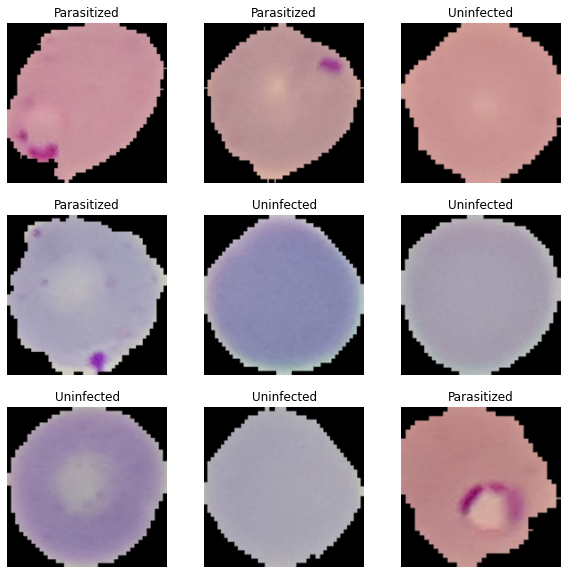

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Model

## Configure the dataset and data augmentation

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [35]:
num_classes = len(class_names)

## Creating the model itself

In [37]:

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [40]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
603/603 [==============================] - 33s 53ms/step - loss: 0.3862 - accuracy: 0.8140 - val_loss: 0.1753 - val_accuracy: 0.9427
Epoch 2/15
603/603 [==============================] - 32s 52ms/step - loss: 0.1869 - accuracy: 0.9382 - val_loss: 0.1734 - val_accuracy: 0.9427
Epoch 3/15
603/603 [==============================] - 31s 52ms/step - loss: 0.1645 - accuracy: 0.9483 - val_loss: 0.1537 - val_accuracy: 0.9548
Epoch 4/15
603/603 [==============================] - 31s 52ms/step - loss: 0.1571 - accuracy: 0.9526 - val_loss: 0.1441 - val_accuracy: 0.9583
Epoch 5/15
603/603 [==============================] - 32s 52ms/step - loss: 0.1568 - accuracy: 0.9514 - val_loss: 0.1350 - val_accuracy: 0.9575
Epoch 6/15
603/603 [==============================] - 31s 52ms/step - loss: 0.1402 - accuracy: 0.9558 - val_loss: 0.1308 - val_accuracy: 0.9581
Epoch 7/15
603/603 [==============================] - 31s 52ms/step - loss: 0.1375 - accuracy: 0.9553 - val_loss: 0.1301 - val_accuracy:

# Evaluation

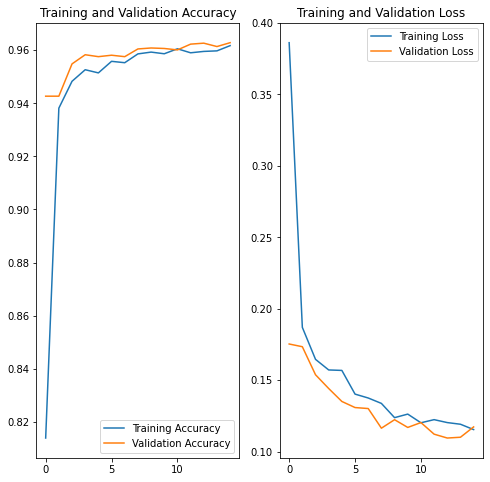

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()